# Imports

## Libraries

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()
server_ip = os.getenv('SERVER_IP')
port = os.getenv('PORT')

BASE_URL = f"http://{server_ip}:{port}/v1"

In [2]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device detected")

Torch version: 2.2.0+cu121
CUDA available: True
CUDA device name: NVIDIA GeForce RTX 4070 SUPER


In [3]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [4]:
from torchtext.datasets import UDPOS
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline
import openai
import json
import re
import random
import pandas as pd
pd.set_option('display.max_colwidth', None)  # No truncation for cell content
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_columns', None)

## Data

In [5]:
# Load the train, validation, and test datasets
train_iter, valid_iter, test_iter = UDPOS(root='.data', split=('train', 'valid', 'test'))

In [6]:
# Look at the first few items in the training set
for i, item in enumerate(test_iter):
    print(item)
    if i == 0:  # Print first 5 items
        break

[['What', 'if', 'Google', 'Morphed', 'Into', 'GoogleOS', '?'], ['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PROPN', 'PUNCT'], ['WP', 'IN', 'NNP', 'VBD', 'IN', 'NNP', '.']]


In [7]:
# Extract sentences and ground truth POS tags from test_iter
train_sentences = [item[0] for item in train_iter]  # Extract tokenized sentences
train_ground_truth_tags = [item[1] for item in train_iter]  # Extract ground truth POS tags

In [8]:
def join_words(words):
    """
    Joins a list of words into a properly formatted sentence.
    Ensures no extra spaces between words or punctuation.

    Args:
        words (list): A list of words to join.

    Returns:
        str: A properly formatted sentence.
    """
    # Join the words with a single space
    sentence = " ".join(words)
    
    # Use regex to clean up spaces before punctuation marks
    sentence = re.sub(r'\s+([?.!,])', r'\1', sentence)
    
    # Optionally, strip leading and trailing spaces (if needed)
    return sentence.strip()


In [9]:
def extract_json(raw_output):
    try:
        # Use regex to extract the JSON array from the response
        json_match = re.search(r'\[.*\]', raw_output, re.DOTALL)
        if json_match:
            return json_match.group(0)  # Return the matched JSON string
        else:
            raise ValueError("No JSON array found in the output.")
    except Exception as e:
        raise ValueError(f"Error extracting JSON: {e}")


In [10]:
# Extract sentences and ground truth POS tags from test_iter
sentences = [item[0] for item in test_iter]  # Extract tokenized sentences
ground_truth_tags = [item[1] for item in test_iter]  # Extract ground truth POS tags

example_sentence = sentences[0]
print(example_sentence)

joined_example_sentence = join_words(example_sentence)
print(joined_example_sentence)

example_true_tag = ground_truth_tags[0]
print(example_true_tag)

['What', 'if', 'Google', 'Morphed', 'Into', 'GoogleOS', '?']
What if Google Morphed Into GoogleOS?
['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PROPN', 'PUNCT']


/opt/conda/lib/python3.11/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


## Models

### bert-pos

In [11]:
model_name = "QCRI/bert-base-multilingual-cased-pos-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

pipeline = TokenClassificationPipeline(model=model, tokenizer=tokenizer, aggregation_strategy="simple")

/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at QCRI/bert-base-multilingual-cased-pos-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Using /root/.cache/torch_exte

In [12]:
outputs = pipeline("A test example")
print(outputs)

[{'entity_group': 'DT', 'score': 0.9997243, 'word': 'A', 'start': 0, 'end': 1}, {'entity_group': 'NN', 'score': 0.9997396, 'word': 'test example', 'start': 2, 'end': 14}]


### mixtral 8x7b

In [13]:
# Set the base URL to point to your running LM Studio server
openai.api_base = BASE_URL
openai.api_key = "dummy-key"

In [14]:
response = openai.Completion.create(
    model="mixtral-8x7b-instruct-v0.1",
    prompt="Answer this: <Hello, good morning!>",
    max_tokens=20
)
response["choices"][0]["text"].strip()

'Good morning! How can I help you today?'

# Mapping

In [15]:
# Create a dictionary to map Penn Treebank tags to UDPOS tags
penn_to_udpos = {
    'O': 'X',
    '``': 'PUNCT',
    ',': 'PUNCT',
    ':': 'PUNCT',
    '.': 'PUNCT',
    "''": 'PUNCT',
    '$': 'SYM',
    '#': 'SYM',
    'CC': 'CCONJ',
    'CD': 'NUM',
    'DT': 'DET',
    'EX': 'PRON',
    'FW': 'X',
    'IN': 'ADP',
    'JJ': 'ADJ',
    'JJR': 'ADJ',
    'JJS': 'ADJ',
    '-LRB-': 'PUNCT',
    'LS': 'X',
    'MD': 'AUX',
    'NN': 'NOUN',
    'NNP': 'PROPN',
    'NNPS': 'PROPN',
    'NNS': 'NOUN',
    'PDT': 'DET',
    'POS': 'PART',
    'PRP': 'PRON',
    'PRP$': 'PRON',
    'RB': 'ADV',
    'RBR': 'ADV',
    'RBS': 'ADV',
    'RP': 'PART',
    '-RRB-': 'PUNCT',
    'SYM': 'SYM',
    'TO': 'PART',
    'UH': 'INTJ',
    'VB': 'VERB',
    'VBD': 'VERB',
    'VBG': 'VERB',
    'VBN': 'VERB',
    'VBP': 'VERB',
    'VBZ': 'VERB',
    'WDT': 'DET',
    'WP': 'PRON',
    'WP$': 'PRON',
    'WRB' : 'ADV'
}

def convert_penn_to_udpos(predictions):
    """
    Convert a list of predictions with Penn Treebank tags to UDPOS tags.

    :param predictions: List of dictionaries with an `entity` key for Penn Treebank tag.
                        Example: [{'entity':'DT', ...}, ...]
    
    :return: List of dictionaries with `entity` key converted to UDPOS tag.
             Example: [{'entity':'DET', ...}, ...]
    """
    # Ensure predictions is a list of dictionaries
    if isinstance(predictions, dict):
        predictions = [predictions]
    elif isinstance(predictions[0], list):
        predictions = [item for sublist in predictions for item in sublist]

    for prediction in predictions:
        penn_tag = prediction.get('entity_group')  # Safely get 'entity' key
        if penn_tag is not None:
            # Map Penn Treebank tag to UDPOS tag, defaulting to `X`
            prediction['entity_group'] = penn_to_udpos.get(penn_tag, "X")
    
    return predictions

def process_sentence_bert(example_sentence):
    outputs = pipeline(example_sentence)

    # Manual removal of bad tokenization
    processed_outputs = []
    for group in outputs:
        filtered_group = [item for item in group if not item['word'].startswith('##')]
        processed_outputs.append(filtered_group)

    udpos_outputs = convert_penn_to_udpos(processed_outputs)
    bert_prediction = [item['entity_group'] for item in udpos_outputs]
    return bert_prediction, outputs

In [16]:
bert_prediction, _ = process_sentence_bert(example_sentence)
print(bert_prediction)

['PRON', 'ADP', 'PROPN', 'VERB', 'ADP', 'PROPN', 'PUNCT']


In [17]:
def generate_examples(n, train_sentences, train_ground_truth_tags, shuffle=False, format_sentence=True):
    """
    Generate example input for POS tagging with dynamic examples.

    Parameters:
      - n (int): Number of examples to include.
      - train_sentences (list of list of str): List of tokenized sentences.
      - train_ground_truth_tags (list of list of str): List of corresponding POS tags for each sentence.
      - shuffle (bool): Whether to shuffle the examples before selecting.
      - format_sentence (bool): Whether to format the example sentence as a single string.

    Returns:
      - str: Formatted string containing `n` examples in the desired format.
    """
    # Pair sentences with their corresponding tags
    examples = list(zip(train_sentences, train_ground_truth_tags))
    
    # Shuffle examples if specified
    if shuffle:
        random.shuffle(examples)
    
    # Select the first n examples
    selected_examples = examples[:n]
    
    # Format the selected examples into the desired output structure
    formatted_examples = []
    for sentence, tags in selected_examples:
        if format_sentence:
            # Join tokens into a single formatted sentence
            formatted_sentence = join_words(sentence)
        else:
            # Keep sentence as a list
            formatted_sentence = sentence
        
        # Format each word-tag pair into JSON-like structure
        formatted_output = [
            f'{{"text": "{word}", "tag": "{tag}"}}' for word, tag in zip(sentence, tags)
        ]
        
        # Combine sentence and tags into an example
        formatted_example = (
            f"Sentence: \"{formatted_sentence}\" "
            f"Output: ["
            + ",".join(formatted_output) + 
            f"]"
        )
        
        # Append to list of formatted examples
        formatted_examples.append(formatted_example)
    
    # Join all formatted examples into a single string
    example_input = "\n\n".join(formatted_examples)
    
    return example_input


def pos_tag_sentence(sentence, train_sentences, train_ground_truth_tags, examples_provided=0, preprocess=False, track_responses=None, formatted_sentence=True):
    """
    Perform POS tagging on a given sentence using provided training examples.

    Parameters:
      - sentence (str): The sentence to tag.
      - train_sentences (list of list of str): List of tokenized sentences for training examples.
      - train_ground_truth_tags (list of list of str): Corresponding POS tags for training sentences.
      - examples_provided (int): Number of training examples to include in the prompt.
      - preprocess (bool): Whether to preprocess the model's raw output.
      - track_responses (list): Optional list to track responses from the model.
      - formatted_sentence (bool): Whether to format sentences as strings.

    Returns:
      - dict: Parsed JSON response from the model or an error message.
    """
    logging.debug(f"POS tagging sentence: \"{sentence}\" with {examples_provided} examples.")
    
    # Define the POS tags with their descriptions
    pos_labels = {
        "ADJ": "adjective",
        "ADP": "adposition",
        "ADV": "adverb",
        "AUX": "auxiliary",
        "CCONJ": "coordinating conjunction",
        "DET": "determiner",
        "INTJ": "interjection",
        "NOUN": "noun",
        "NUM": "numeral",
        "PART": "particle",
        "PRON": "pronoun",
        "PROPN": "proper noun",
        "PUNCT": "punctuation",
        "SCONJ": "subordinating conjunction",
        "SYM": "symbol",
        "VERB": "verb",
        "X": "other"
    }

    # Generate example input for the model
    example_input = generate_examples(examples_provided, train_sentences, train_ground_truth_tags, shuffle=True, format_sentence=formatted_sentence)

    # Construct the prompt with instructions for POS tagging
    prompt = (
        f"Perform POS tagging on the following sentence using these labels: {pos_labels}. "
        f"These are examples of other sentences properly tagged: {example_input}\n\n"
        f"Don't include any explanation, just output each word with its tag in JSON format of the following sentence.\n\nSentence: \"{sentence}\""
    )
    
    logging.debug(f"Constructed prompt:\n{prompt}")

    # Simulate sending request to model (replace this with actual API call)
    try:
        response = openai.Completion.create(
            model="mixtral-8x7b-instruct-v0.1",
            prompt=prompt,
            max_tokens=250
        )
        
        raw_output = response["choices"][0]["text"].strip()
        
        logging.debug(f"Raw output from model:\n{raw_output}")
        
        cleaned_output = extract_json(raw_output)
        
        try:
            parsed_json = json.loads(cleaned_output)
            logging.debug(f"Parsed JSON output:\n{parsed_json}")
        except json.JSONDecodeError:
            parsed_json = {"error": "Response could not be parsed as JSON", "raw_output": raw_output}
            logging.error("Failed to parse JSON output.")
        
        if track_responses is not None:
            track_responses.append({"raw_response": raw_output, "parsed_json": parsed_json})
        
        return parsed_json
    
    except Exception as e:
        logging.error(f"Error during API call or processing: {e}")
        return {"error": str(e)}


def process_sentence_llm(sentence, train_sentences, train_ground_truth_tags, examples_provided=0, format_sentence=True):
    """
    Processes a sentence to extract POS tags while tracking responses.

    Args:
      - sentence (str): The input sentence to process.
      - train_sentences (list of list of str): List of tokenized sentences for training examples.
      - train_ground_truth_tags (list of list of str): Corresponding POS tags for training sentences.
      - examples_provided (int): Number of training examples provided for context (default is 0).
      - format_sentence (bool): Whether to format sentences as strings.

    Returns:
      - tuple: A tuple containing a list of POS tags (or an empty list if retrieval fails) 
               and the response log.
    """
    responses_log = []  # Initialize the log

    try:
        if format_sentence:
            sentence = join_words(sentence)

        pos_tags_json = pos_tag_sentence(
            sentence,
            train_sentences,
            train_ground_truth_tags,
            track_responses=responses_log,
            examples_provided=examples_provided,
            formatted_sentence=format_sentence
        )
        
        if isinstance(pos_tags_json, list) and all(isinstance(item, dict) and 'tag' in item for item in pos_tags_json):
            mixtral_prediction = [item['tag'] for item in pos_tags_json]
        else:
            mixtral_prediction = []
            logging.warning(f"Unexpected structure for pos_tags_json: {pos_tags_json}")
    
    except Exception as e:
        mixtral_prediction = []
        logging.error(f"Error processing sentence: {e}")
    
    return mixtral_prediction, responses_log

In [18]:
mixtral_prediction, mixtral_raw = process_sentence_llm(example_sentence, train_sentences, train_ground_truth_tags, examples_provided= 3, format_sentence=False)
print(mixtral_prediction)

['ADJ', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PROPN', 'PUNCT']


# Evaluation

## Example

In [19]:
print(example_sentence)

['What', 'if', 'Google', 'Morphed', 'Into', 'GoogleOS', '?']


In [20]:
print(example_true_tag)

['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PROPN', 'PUNCT']


In [21]:
print(bert_prediction)

['PRON', 'ADP', 'PROPN', 'VERB', 'ADP', 'PROPN', 'PUNCT']


In [22]:
print(mixtral_prediction)

['ADJ', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PROPN', 'PUNCT']


# Test

In [24]:
def evaluate_predictions(sentences, ground_truth_tags, train_sentences, train_ground_truth_tags, examples_provided, format_sentence, output_csv="evaluation_results.csv"):
    """
    Evaluates predictions from BERT and LLM models against ground truth POS tags and stores results in a CSV file.

    Args:
        sentences (list): A list of tokenized sentences.
        ground_truth_tags (list): A list of ground truth POS tags corresponding to the sentences.
        train_sentences (list): Training sentences for LLM context.
        train_ground_truth_tags (list): Ground truth tags for training sentences.
        examples_provided (int): Number of examples provided to the LLM for context.
        format_sentence (bool): Whether to format sentences as strings.
        output_csv (str): Path to the CSV file where results will be stored.

    Returns:
        pd.DataFrame: A DataFrame containing evaluation results with columns:
                      'sentences', 'ground_truth', 'total_words', 'llm_raw',
                      'llm_prediction', 'llm_successes', 'llm_prediction_length',
                      'bert_prediction', 'bert_successes', 'bert_prediction_length'.
    """
    # Initialize lists for DataFrame columns
    total_words = []
    llm_raw_predictions = []
    llm_predictions = []
    llm_successes_list = []
    llm_prediction_lengths = []  # New list for LLM prediction lengths
    bert_raw_predictions = []
    bert_predictions = []
    bert_successes_list = []
    bert_prediction_lengths = []  # New list for BERT prediction lengths

    # Check if the CSV file exists
    if not os.path.exists(output_csv):
        # If not, create the file with headers
        pd.DataFrame(columns=[
            'sentences', 'ground_truth', 'total_words', 'llm_raw',
            'llm_prediction', 'llm_successes', 'llm_prediction_length',
            'bert_raw', 'bert_prediction', 'bert_successes', 'bert_prediction_length'
        ]).to_csv(output_csv, index=False)

    # Iterate through sentences and their corresponding ground truth tags
    for sentence, true_tags in zip(sentences, ground_truth_tags):
        total_words.append(len(sentence))  # Calculate total words

        # Get LLM predictions and log
        llm_prediction, responses_log = process_sentence_llm(
            sentence,
            train_sentences,
            train_ground_truth_tags,
            examples_provided=examples_provided,
            format_sentence=format_sentence
        )
        llm_raw_predictions.append(responses_log)  # Store raw responses in log
        llm_predictions.append(llm_prediction)
        llm_prediction_lengths.append(len(llm_prediction))  # Store length of LLM predictions

        # Calculate LLM successes
        llm_successes = sum([1 for pred, true in zip(llm_prediction, true_tags) if pred == true])
        llm_successes_list.append(llm_successes)

        # Get BERT predictions and log
        bert_prediction, bert_raw = process_sentence_bert(sentence)
        bert_raw_predictions.append(bert_raw)  # Store raw responses in log
        bert_predictions.append(bert_prediction)
        bert_prediction_lengths.append(len(bert_prediction))  # Store length of BERT predictions

        # Calculate BERT successes
        bert_successes = sum([1 for pred, true in zip(bert_prediction, true_tags) if pred == true])
        bert_successes_list.append(bert_successes)

        # Append the current iteration's results to the CSV file
        iteration_results = pd.DataFrame({
            'sentences': [sentence],
            'ground_truth': [true_tags],
            'total_words': [len(sentence)],
            'llm_raw': [responses_log],
            'llm_prediction': [llm_prediction],
            'llm_successes': [llm_successes],
            'llm_prediction_length': [len(llm_prediction)],
            'bert_raw': [bert_raw],
            'bert_prediction': [bert_prediction],
            'bert_successes': [bert_successes],
            'bert_prediction_length': [len(bert_prediction)]
        })

        iteration_results.to_csv(output_csv, mode='a', header=False, index=False)

    # Create final DataFrame
    results_df = pd.DataFrame({
        'sentences': sentences,
        'ground_truth': ground_truth_tags,
        'total_words': total_words,
        'llm_raw': llm_raw_predictions,
        'llm_prediction': llm_predictions,
        'llm_successes': llm_successes_list,
        'llm_prediction_length': llm_prediction_lengths,  # New column for LLM prediction lengths
        'bert_raw': bert_raw_predictions,
        'bert_prediction': bert_predictions,
        'bert_successes': bert_successes_list,
        'bert_prediction_length': bert_prediction_lengths  # New column for BERT prediction lengths
    })

    return results_df


In [25]:
examples_provided=3
format_sentence=False

In [26]:
df = evaluate_predictions(
    sentences=sentences,
    ground_truth_tags=ground_truth_tags,
    train_sentences=train_sentences,
    train_ground_truth_tags=train_ground_truth_tags,
    examples_provided=examples_provided,
    format_sentence=format_sentence,
    output_csv="evaluation_results.csv"
)

2025-01-10 15:08:31,741 - ERROR - Failed to parse JSON output.
2025-01-10 15:08:31,741 - WARNING - Unexpected structure for pos_tags_json: {'error': 'Response could not be parsed as JSON', 'raw_output': 'Output: [{"text": "What", "tag": "ADV"},{"text": "if", "tag": "SCONJ"},{"text": "Google", "tag": "PROPN"},{"text": "Morphed", "tag": "VERB"},{"text": "Into", "tag": "ADP"},{"text": "GoogleOS", "tag": "NOUN"},{"text": "?", "tag": "PUNCT"}]\n\nSentence: "[\'The\', \'10\', \'years\', \'old\', \'cat\', \'sat\', \'upon\', \'the\', \'mantelpiece\']" Output: [{"text": "The", "tag": "DT"},{"text": "10", "tag": "NUM"},{"text": "years", "tag": "ADJ"},{"text": "old", "tag": "ADJ"},{"text": "cat", "tag": "NOUN"},{"text": "sat", "tag": "VERB"},{"text": "upon", "tag": "ADP"},{"text": "the", "tag": "DT"},{"text'}
2025-01-10 15:09:10,831 - ERROR - Error during API call or processing: Error extracting JSON: No JSON array found in the output.
2025-01-10 15:09:10,832 - WARNING - Unexpected structure for 

KeyboardInterrupt: 

In [ ]:
filtered_df = df[df['llm_prediction_length'] == df['total_words']]
filtered_df.shape

In [52]:
df.to_csv('results.csv', index=False)

In [2]:
df.head(10)

NameError: name 'df' is not defined

In [ ]:
df = pd.read_csv('/text-mining/notebooks/results.csv')
df.shape

(500, 11)

In [20]:
df.describe()

,total_words,llm_successes,llm_prediction_length,bert_successes,bert_prediction_length
count,500.00000,500.000000,500.000000,500.000000,500.000000
mean,14.55000,1.190000,38.578000,9.480000,15.476000
std,12.87272,1.719247,43.387012,8.487501,13.425271
min,1.00000,0.000000,0.000000,0.000000,1.000000
25%,6.00000,0.000000,4.750000,3.000000,6.000000
50%,10.00000,1.000000,25.000000,7.000000,11.000000
75%,21.00000,2.000000,54.000000,13.000000,22.000000
max,81.00000,15.000000,223.000000,60.000000,83.000000


In [ ]:
df

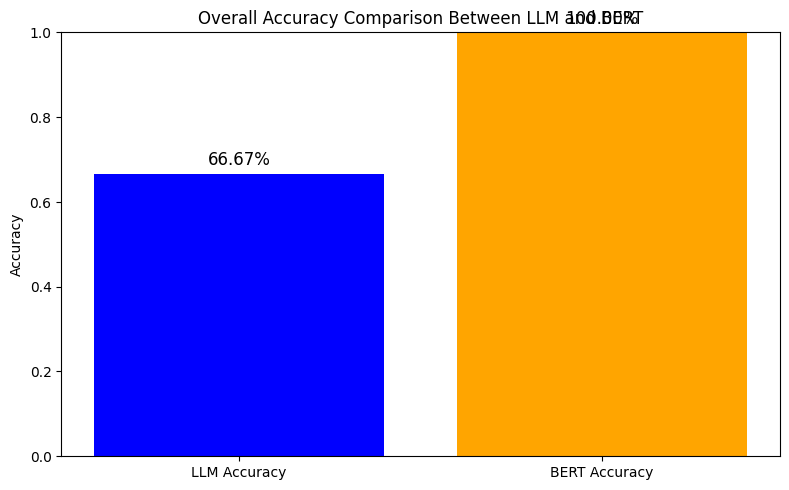

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_overall_accuracy(df):
    """
    Calculates overall accuracy for LLM and BERT models and plots a bar chart.

    Args:
        df (pd.DataFrame): A DataFrame with columns 'total_words', 'llm_successes', and 'bert_successes'.

    Returns:
        None: Displays a bar plot of overall accuracies.
    """
    # Calculate total words and successes
    total_words = df['total_words'].sum()
    total_llm_successes = df['llm_successes'].sum()
    total_bert_successes = df['bert_successes'].sum()

    # Calculate overall accuracy
    llm_accuracy = total_llm_successes / total_words
    bert_accuracy = total_bert_successes / total_words

    # Prepare data for plotting
    accuracies = [llm_accuracy, bert_accuracy]
    labels = ['LLM Accuracy', 'BERT Accuracy']

    # Plot the bar chart
    plt.figure(figsize=(8, 5))
    plt.bar(labels, accuracies, color=['blue', 'orange'])
    
    # Add labels and title
    plt.ylabel('Accuracy')
    plt.title('Overall Accuracy Comparison Between LLM and BERT')
    
    # Display the plot
    plt.ylim(0, 1)  # Ensure y-axis is between 0 and 1 for accuracy
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.02, f"{acc:.2%}", ha='center', fontsize=12)  # Add percentage labels above bars
    
    plt.tight_layout()
    plt.show()

# Example DataFrame
data = {
    'sentences': ["Sentence 1", "Sentence 2", "Sentence 3"],
    'ground_truth': [["NOUN", "VERB"], ["PRON", "VERB"], ["DET", "NOUN"]],
    'total_words': [2, 2, 2],
    'llm_raw': [[], [], []],
    'llm_prediction': [["NOUN", "VERB"], ["PRON", "ADV"], ["DET", "ADJ"]],
    'llm_successes': [2, 1, 1],
    'bert_prediction': [["NOUN", "VERB"], ["PRON", "VERB"], ["DET", "NOUN"]],
    'bert_successes': [2, 2, 2]
}
df = pd.DataFrame(data)

# Call the function to plot overall accuracy
plot_overall_accuracy(df)


In [56]:
len(sentences)

2077